In [15]:
import time
import torch
import os
import pytorch_lightning as pl
import logging
import numpy as np
import matplotlib.pyplot as plt

from utils import tools, callbacks, metrics, supported_preprocessing_transforms
from modules.cae_base_module import CAEBaseModule
from datasets import supported_datamodules
from models import supported_models

In [2]:
config = tools.load_config('../logs/LunarAnalogueDataModule/BaselineCAE/archive_nre1_2021-05-02/configuration.yaml')

ptransf = supported_preprocessing_transforms[config['data-parameters']['preprocessing']]

dm = supported_datamodules[config['experiment-parameters']['datamodule']](
    data_transforms=ptransf,
    **config['data-parameters'])
dm.setup('test')

model = supported_models[config['experiment-parameters']['model']](dm.data_shape)

module = CAEBaseModule(model, **config['module-parameters'])

# Load the state_dict into the module architecture
checkpoint = torch.load('../logs/LunarAnalogueDataModule/BaselineCAE/archive_nre1_2021-05-02/checkpoints/val_loss=0.01-epoch=7.ckpt')
module.load_state_dict(checkpoint['state_dict'])

Experimental parameters
------
{'data-parameters': {'batch_size': 32,
                     'glob_pattern_test': None,
                     'glob_pattern_train': None,
                     'preprocessing': 'LunarAnalogueRegionExtractor',
                     'root_data_path': '/home/brahste/Datasets/NoveltyLunarAnalogue',
                     'train_fraction': None,
                     'use_nre_collation': True},
 'experiment-parameters': {'datamodule': 'LunarAnalogueDataModule',
                           'log_dir': 'logs',
                           'model': 'BaselineCAE',
                           'patience': None},
 'module-parameters': {'learning_rate': 0.0009120108393559097,
                       'weight_decay_coefficient': 0.1}}


<All keys matched successfully>

In [3]:
# Collect scores and labels for all models into a catalog

test_novelty_scores = []
test_novelty_labels = []

module.model.eval()  # Freeze dropout and batch normalization parameters

with torch.no_grad():
    for batch_nb, batch in enumerate(dm.test_dataloader()):

        # Need to implement custom testing to manage regions
        batch_in, batch_labels = module.handle_batch_shape(batch)
        batch_lt = module.model.encoder(batch_in)
        batch_rc = module.model.decoder(batch_lt)
        loss = module.loss_function(batch_rc, batch_in)
        
        for x_rc, x_in in zip(batch_rc, batch_in):
            test_novelty_scores.append(module.loss_function(x_rc, x_in))

        test_novelty_labels.append(batch_labels)
        print(f'[BATCH {batch_nb}] Mean score: {loss.mean()}')

[BATCH 0] Mean score: 0.008089265786111355
[BATCH 1] Mean score: 0.007363653276115656
[BATCH 2] Mean score: 0.008080060593783855
[BATCH 3] Mean score: 0.007389832753688097
[BATCH 4] Mean score: 0.0075438860803842545
[BATCH 5] Mean score: 0.00857859943062067
[BATCH 6] Mean score: 0.00763392448425293
[BATCH 7] Mean score: 0.008313609287142754
[BATCH 8] Mean score: 0.010043047368526459
[BATCH 9] Mean score: 0.010335955768823624
[BATCH 10] Mean score: 0.009541589766740799
[BATCH 11] Mean score: 0.009673045016825199
[BATCH 12] Mean score: 0.00887273345142603
[BATCH 13] Mean score: 0.009617906995117664
[BATCH 14] Mean score: 0.009262076579034328
[BATCH 15] Mean score: 0.009458732791244984
[BATCH 16] Mean score: 0.009197180159389973
[BATCH 17] Mean score: 0.009392841719090939
[BATCH 18] Mean score: 0.008997992612421513
[BATCH 19] Mean score: 0.009423185139894485
[BATCH 20] Mean score: 0.009884021244943142
[BATCH 21] Mean score: 0.009759997017681599
[BATCH 22] Mean score: 0.00907106976956129
[

In [7]:
# Here we extract the labels to match the number of crops obtained
scores = np.array(test_novelty_scores)
labels = np.array(test_novelty_labels)
print(scores.shape)
print(labels.shape)

gt_bboxes = []
cr_bboxes = []

for batch_labels in test_novelty_labels:
    gtbb = batch_labels['gt_bboxes'].reshape(-1, 4)
    crbb = batch_labels['cr_bboxes'].reshape(-1, 4)
    gt_bboxes.extend(gtbb)
    cr_bboxes.extend(crbb)
    
gt_bboxes = np.array(gt_bboxes)
cr_bboxes = np.array(cr_bboxes)

(13312,)
(26,)


In [54]:
print(gt_bboxes.shape)
print(cr_bboxes.shape)
ious = []
binary_labels = []  # IOU > 0.5 counts as a label

n_dups = 0

for i, (gt, cr) in enumerate(zip(gt_bboxes, cr_bboxes)):
    
    cr = cr * 5
    iou = metrics.iou(cr, gt)
    ious.append(iou)
    
    if iou > 0.7:
        binary_labels.append(1)
        if i != 0:
            if all(gt == prev_gt):
                n_dups += 1
        prev_gt = gt
    else:
        binary_labels.append(0)
    
    
ious = np.array(ious)
binary_labels = np.array(binary_labels)
print(ious.shape)
print(binary_labels.shape)
print(sum(binary_labels))
print(n_dups)

(13312, 4)
(13312, 4)
(13312,)
(13312,)
55
0


In [55]:
fpr, tpr, thresholds, auc = metrics.roc(scores, binary_labels)

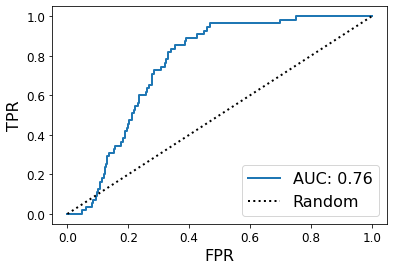

Random ROC AUC: 0.5


In [56]:
plt.plot(fpr, tpr, lw=2., label=f'AUC: {auc:.2f}')
plt.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random')
plt.legend(fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.show()
print('Random ROC AUC: 0.5')

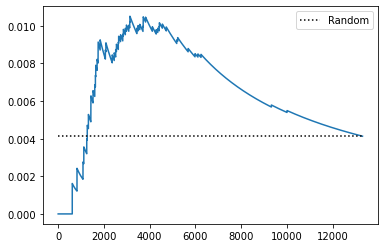

In [60]:

pak = metrics.precision_at_k(scores, binary_labels)

uniques, counts = np.unique(binary_labels, return_counts=True)
random = counts.min() / counts.sum()

plt.plot(pak)
    
plt.plot([0, len(pak)], [random, random], 'k:', label='Random')
# plt.ylim([0., 1.])
plt.legend()
plt.show()

In [90]:
%matplotlib qt
typical_scores = scores[[not bool(b) for b in binary_labels]]

novel_scores = scores[[bool(b) for b in binary_labels]]

# plt.hist(scores, bins=25)
plt.hist(novel_scores, bins=25, label='Novel', alpha=0.5)
plt.hist(typical_scores, bins=25, label='Typical', alpha=0.5)

plt.legend()
plt.show()

2021-05-03 15:33:01,886 - DEBUG - Loaded backend Qt5Agg version unknown.
